La fraude en ligne est une préoccupation majeure pour toutes les entreprises qui gèrent
 des paiements numériques, car elle entraîne des pertes financières importantes et diminue la confiance des clients. Dans le cadre
 de ce projet nous souhaitons développer des modèles de machines learning fiables qui identifient les transactions à partir de vastes ensembles
 de données transactionnelles et comportementales et des informations sur les appareils utilisés. Nous avons un problème de classification
 binaire avec un fort déséquilibre. Dans un premier temps nous allons explorer les données et essaierons de trouver des informations précieuses 
 avant de passser au modèle.
 

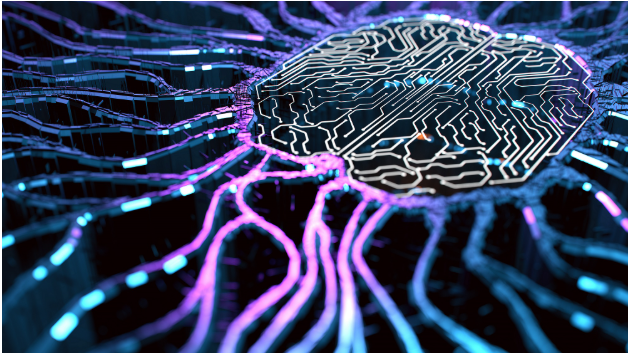

In [61]:
!pip install -U vega_datasets notebook vega > nul 2>&1

In [62]:
#!pip install hyperopt

In [63]:
#!pip install optuna

In [64]:
!pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
%%capture
!pip install lightgbm xgboost catboost shap eli5 networkx

In [66]:
!pip install --upgrade lightgbm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
pip install -U xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
pip install -U lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Packages

In [69]:
# Traitement des données
import pandas as pd
import numpy as np
import gc
from pathlib import Path

# Encodage
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import altair as alt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
import xgboost as xgb
from lightgbm import LGBMClassifier, early_stopping
import lightgbm as lgb

# Divers
import optuna
import pickle
# from ydata_profiling import ProfileReport  # si tu veux un profil exploratoire
from yellowbrick.regressor import ResidualsPlot

# Activation du renderer Altair 
alt.renderers.enable('default')


RendererRegistry.enable('default')

In [70]:
#!pip install scikit-learn
!pip install scikit-learn pandas numpy matplotlib seaborn missingno plotly altair yellowbrick xgboost lightgbm optuna




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Les données sont séparées en deux bases. Une des bases donne des informations sur les transactions et l'autre base sur l'identité des clients.

## Importations des données

In [71]:
#Importation des données
# Return a new path pointing to the current working directory
HOME_DIR = Path.cwd()

# create a variable for data directory
DATA_DIR = Path(HOME_DIR, "data")

print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Work directory: c:\Users\pc\Desktop\ENSAE2024-2025\Projet ML\Projet ML 
Data directory: c:\Users\pc\Desktop\ENSAE2024-2025\Projet ML\Projet ML\data


In [72]:
train_transaction = pd.read_csv(Path(DATA_DIR, "train_transaction.csv"), sep=",")
train_transaction.shape

(590540, 394)

In [73]:
print(train_transaction["card4"].unique)

<bound method Series.unique of 0           discover
1         mastercard
2               visa
3         mastercard
4         mastercard
             ...    
590535          visa
590536    mastercard
590537    mastercard
590538    mastercard
590539    mastercard
Name: card4, Length: 590540, dtype: object>


In [74]:
train_identity = pd.read_csv(Path(DATA_DIR, "train_identity.csv"), sep=",")
train_identity.shape

(144233, 41)

In [75]:
test_identity = pd.read_csv(Path(DATA_DIR, "test_identity.csv"), sep=",")
test_identity.shape

(141907, 41)

In [76]:
test_transaction = pd.read_csv(Path(DATA_DIR, "test_transaction.csv"), sep=",")
test_transaction.shape

(506691, 393)

Toutes les transactions ne sont pas dans la base identité. Nous allons  conserver toutes les transactions et merger 
avec la base identité. Les transactions qui ne sont pas dans la base identité auront des valeurs NAN. 

In [77]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [78]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
del train_identity, train_transaction, test_identity, test_transaction

In [80]:
print(f'Nous avons {train.isnull().any().sum()} colonnes qui contiennent de valeurs manquantes dans la base train.')
print(f'Nous avons {test.isnull().any().sum()} colonnes qui contiennent de valeurs manquantes dans la base test.')

Nous avons 414 colonnes qui contiennent de valeurs manquantes dans la base train.
Nous avons 385 colonnes qui contiennent de valeurs manquantes dans la base test.


In [81]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [82]:
print(f'Nous avons {len(one_value_cols)} colonne dans la base train avec 1 valeur.')
print(f'Nous avons {len(one_value_cols_test)} colonne dans la base test avec 1 valeur.')

Nous avons 0 colonne dans la base train avec 1 valeur.
Nous avons 1 colonne dans la base test avec 1 valeur.


Il y a beaucoup de colonnes avec des valeurs manquantes. Une colonne dans la base test avec une seule valeur. 
Dans la suite nous allons explorer d'avantage les données

# Exploration des données

## Variable dépendante

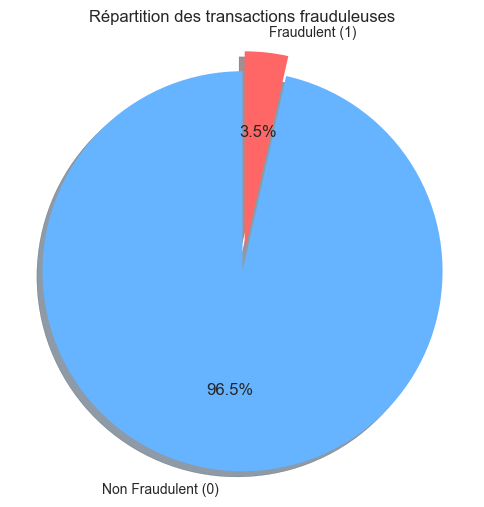

In [83]:
# Compter les valeurs de isFraud et calculer les proportions
fraud_counts = train['isFraud'].value_counts(normalize=True)

# Création du camembert
labels = ['Non Fraudulent (0)', 'Fraudulent (1)']
colors = ['#66b3ff', '#ff6666']  # Couleurs personnalisées
explode = (0, 0.1)  # Met en évidence la partie "fraude"

plt.figure(figsize=(6,6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode, shadow=True)

plt.title('Répartition des transactions frauduleuses')
plt.axis('equal')  # Rend le cercle circulaire
plt.show()

Plus de 96,5% des données sont des données des non frauduleux. Nous pouvons penser à rééquilibrer lors de la modélisation

## Variable indépendantes

Nous pouvons commencer par les informations d'identité. id_01-id_11 sont des variables continues. id_12-id_38 sont des varia
bles catégorielles aussi. Les deux dernières colonnes sont aussi catégorielles.

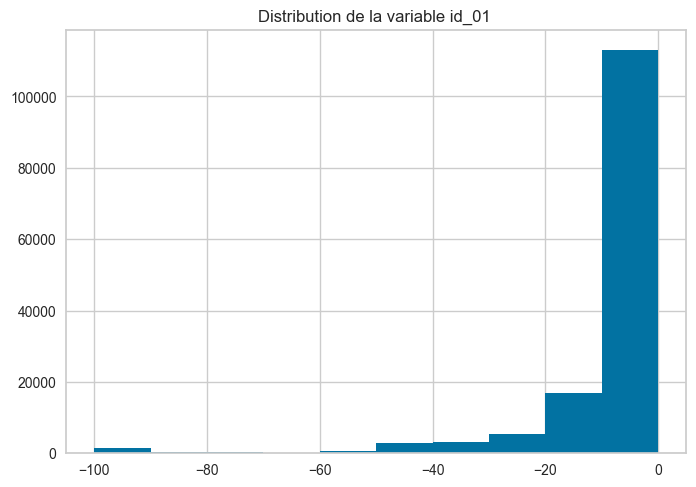

In [84]:
plt.hist(train['id_01']);
plt.title('Distribution de la variable id_01 ');

id_01 prend des valeurs négatives. Nous remarquons aussi une forte présence des valeurs proches de 0.

In [85]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

id_03
NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: proportion, dtype: float64

id_03 a 88,76% de valeurs manquantes. Plus de 98% des valeurs sont soit manquantes soit égal à 0.

In [86]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

id_11
NaN           0.761273
100.000000    0.225492
95.080002     0.002085
95.160004     0.001277
97.120003     0.000745
Name: proportion, dtype: float64

22% des valeurs de id_11 sont égales à 100 et plus de 76% sont des valeurs manquantes.

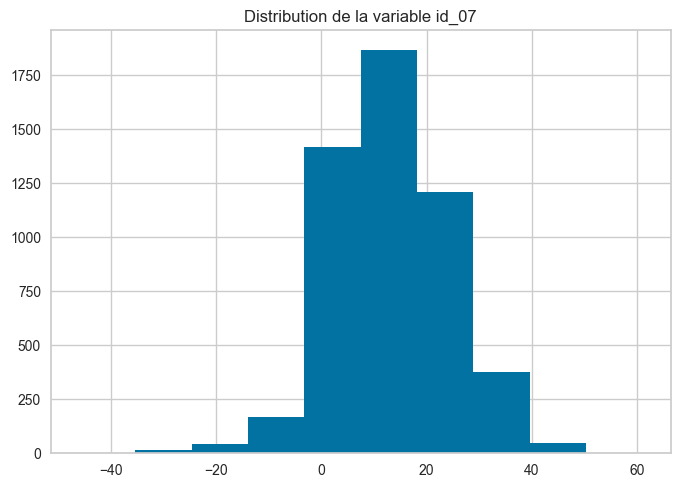

In [87]:
plt.hist(train['id_07']);
plt.title('Distribution de la variable id_07');

La variable semble suivre une distribution normale

In [88]:
charts = {}
features = ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
            'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

for i in features:
    feature_count = train[i].value_counts(dropna=False).reset_index()
    feature_count.columns = [i, f'count_{i}']  # éviter la collision de noms
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
        x=alt.X(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=400)
    
    charts[i] = chart

# Affichage avec Altair (dans un Jupyter Notebook par exemple)
display(
    (charts['id_12'] | charts['id_15'] | charts['id_16']) &
    (charts['id_28'] | charts['id_29'] | charts['id_32']) &
    (charts['id_34'] | charts['id_35'] | charts['id_36']) &
    (charts['id_37'] | charts['id_38'])
)

alt.VConcatChart(...)

Nous remarquons que pour toutes ces variables il y a la présence de beaucoup de données manquantes. Nous remarquons aussi
la présence de beaucoup de variable dichotomique avec comme modalité found, not found ou oui ou non

In [89]:
charts = {}
for i in ['id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']:
    feature_count = train[i].value_counts(dropna=False)[:40].reset_index()
    feature_count.columns = [i, f'count_{i}']  # nom unique pour chaque "count"
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
        y=alt.Y(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=800)
    
    charts[i] = chart

# Affichage
display(charts['id_30'] & charts['id_31'] & charts['id_33'] & charts['DeviceType'] & charts['DeviceInfo'])

alt.VConcatChart(...)

Ici, nous pouvons avoir quelques informations sur les appareils des clients. Il se pourait que les appareils utilisés soient 
anciennes et que dans les données tests ces appareils n'y figurent plus.

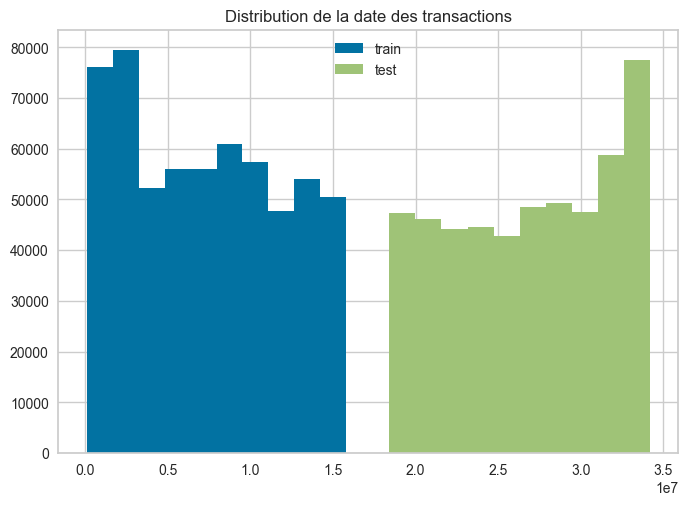

In [90]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution de la date des transactions');

Les dates des transactions pour les données train et test ne se chevauchent pas. Donc pour la validation il serait judicieux
d'utiliser une séparation basée sur le temps. Pour ne pas entrainer les données sur du futur

In [91]:
charts = {}
features = ['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

for i in features:
    feature_count = train[i].value_counts(dropna=False).reset_index()
    feature_count.columns = [i, f'count_{i}']  # nom unique pour chaque colonne de comptage
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
        x=alt.X(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=400)
    
    charts[i] = chart

# Affichage en grille avec Altair
display(
    (charts['ProductCD'] | charts['card4']) &
    (charts['card6'] | charts['M4']) &
    (charts['M1'] | charts['M2']) &
    (charts['M3'] | charts['M5']) &
    (charts['M6'] | charts['M7']) &
    (charts['M8'] | charts['M9'])
)


alt.VConcatChart(...)

On a des informations sur les cartes.

In [92]:
charts = {}
features = ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']

for i in features:
    feature_count = train[i].value_counts(dropna=False).reset_index()[:40]
    feature_count.columns = [i, f'count_{i}']  # colonne count renommée
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
        y=alt.Y(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=600)
    
    charts[i] = chart

# Affichage des graphiques combinés
display(
    (charts['P_emaildomain'] | charts['R_emaildomain']) &
    (charts['card1'] | charts['card2']) &
    (charts['card3'] | charts['card5']) &
    (charts['addr1'] | charts['addr2'])
)

alt.VConcatChart(...)

Nous remarquons qu'il y a des répétitions des données. Par exemple gmail.com et gmail sont une même observations.

# Feature engineering

In [93]:
test.columns = test.columns.str.replace("-", "_")

On harmonise les données

In [94]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')

In [95]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

On sépare les observations à partir du point. Par exemple google.com est google à part et com à part

# Preparation des données

In [96]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [97]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [98]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

84

In [99]:
with open('Mappings/drop_features.pkl', 'wb') as f:
    pickle.dump(cols_to_drop, f)

On supprime les colonnes qui contiennent plus de 90% de valeurs manquantes et les colonnes qui sont peu informatives c'est à
dire les colonnes ou plus de 90% des valeurs sont uniques

In [100]:
train = train.drop([col for col in cols_to_drop if col in train.columns], axis=1)
test = test.drop([col for col in cols_to_drop if col in test.columns], axis=1)

## Labélisation

In [101]:

cat_cols = [
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
    'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
    'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4', 'P_emaildomain',
    'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'M1', 'M2',
    'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain_1', 'P_emaildomain_2', 
    'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3'
]

for col in cat_cols:
    if col in train.columns and col in test.columns:
        le = LabelEncoder()
        # Fusionner les valeurs de train et test pour éviter les erreurs de valeurs inconnues
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))


In [102]:
with open('Mappings/cat_cols_dict.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)

On labélise les variables catégorielles par label encoder

In [103]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [104]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# On remplace les valeurs infinies par Nan pour ne pas créer des erreurs
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

In [105]:
# Pour libérer de l'espace
gc.collect()

73

## Random Forest

Fold 1
AUC: 0.8456


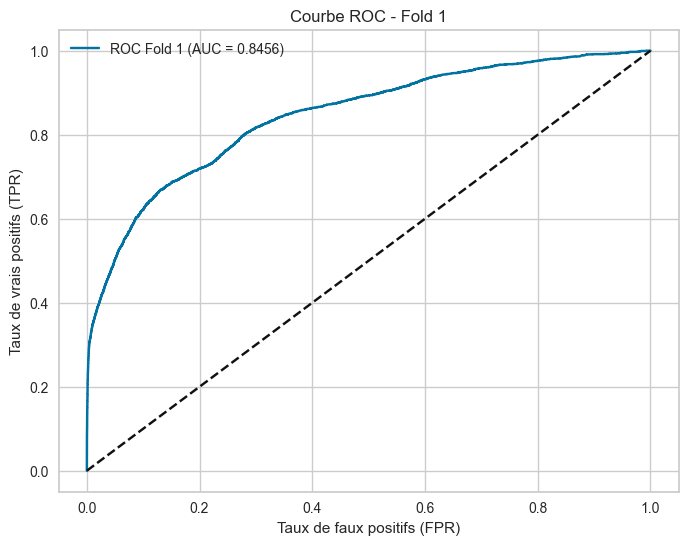

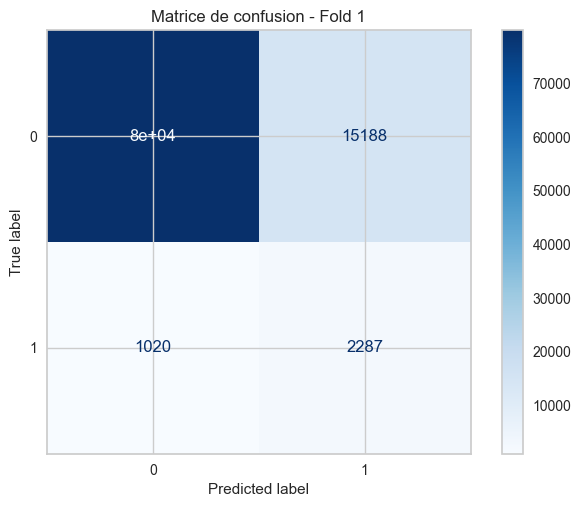

Fold 2
AUC: 0.8609


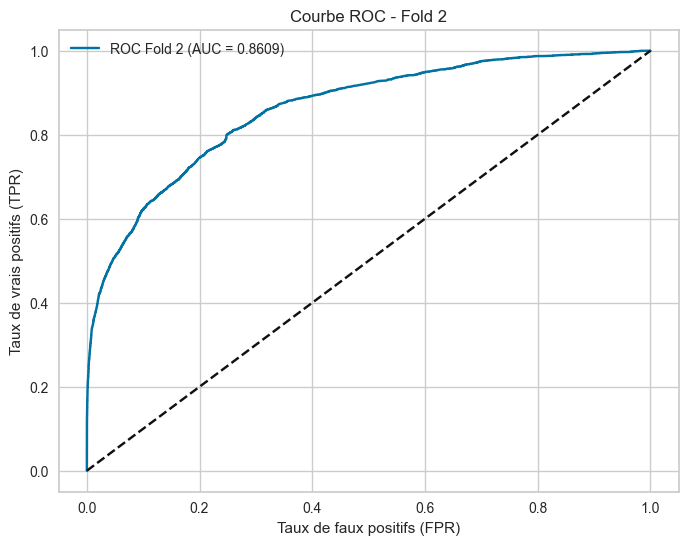

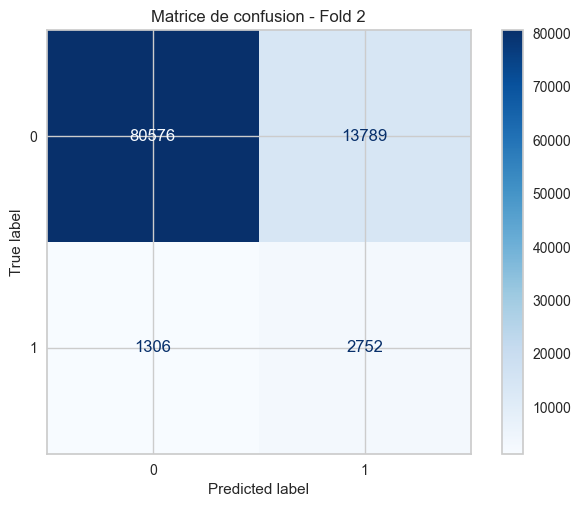

Fold 3
AUC: 0.8526


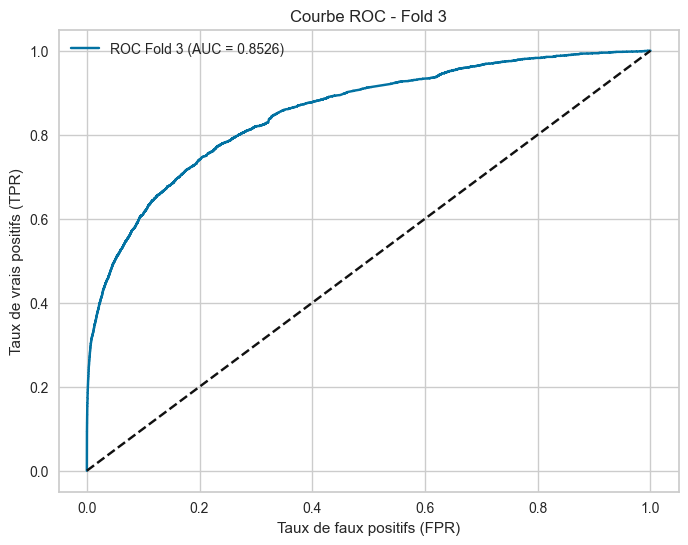

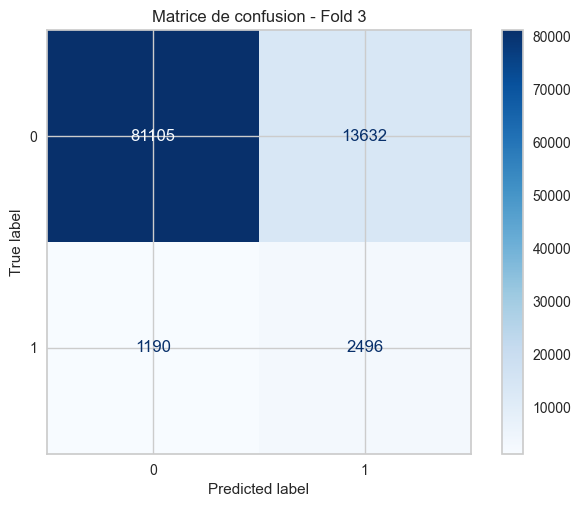

Fold 4
AUC: 0.8580


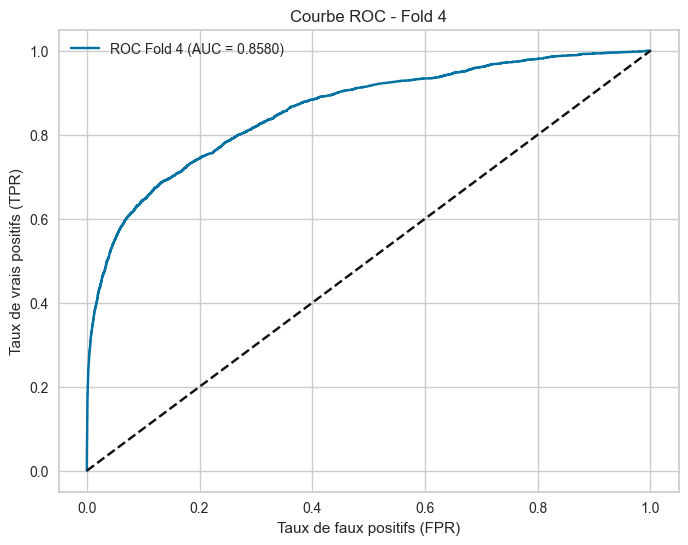

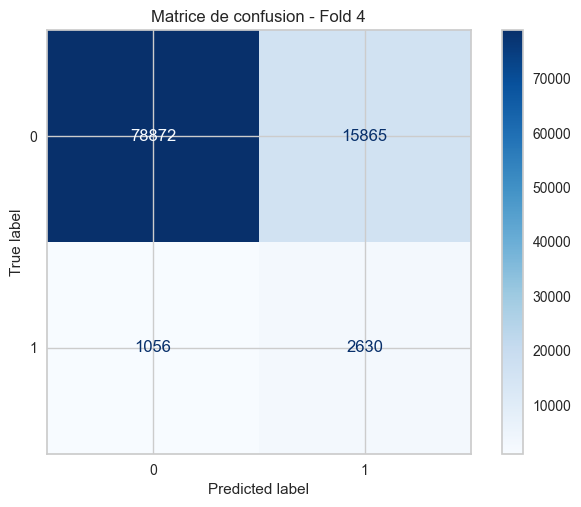

Fold 5
AUC: 0.8581


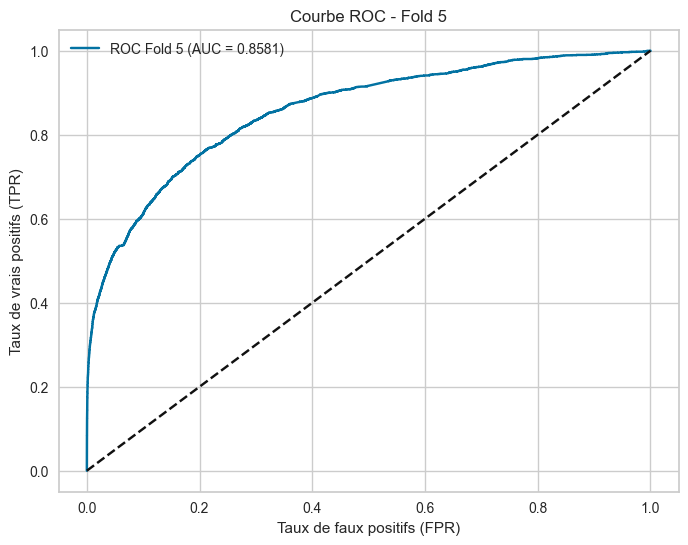

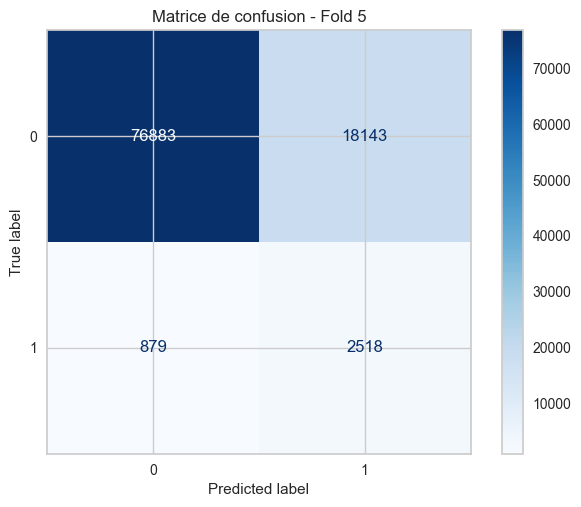

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

params = {
    'n_estimators': 100,
    'max_depth': 6,
    'random_state': 42,
    'class_weight': 'balanced'  # gestion déséquilibre
}

folds = TimeSeriesSplit(n_splits=5)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    auc = roc_auc_score(y_val, y_pred_proba)
    print(f"AUC: {auc:.4f}")
    auc_scores.append(auc)

    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Fold {fold + 1} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title(f"Courbe ROC - Fold {fold + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Matrice de confusion
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matrice de confusion - Fold {fold + 1}")
    plt.show()


## LGBM 

Fold 1
[LightGBM] [Info] Number of positive: 2529, number of negative: 95896
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31728
[LightGBM] [Info] Number of data points in the train set: 98425, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.88754
AUC: 0.8875


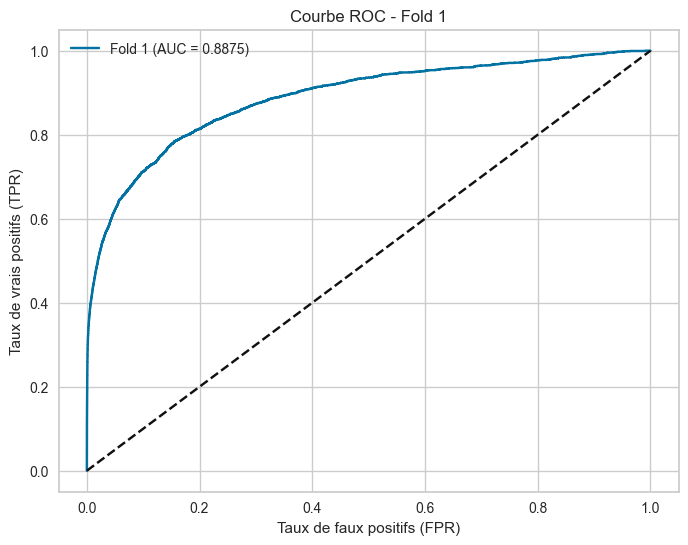

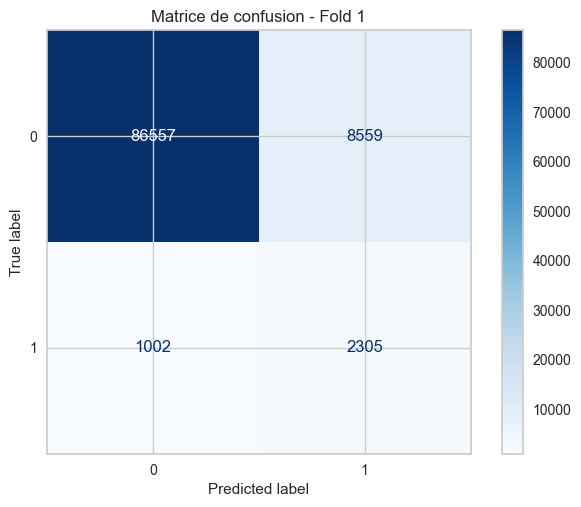

Fold 2
[LightGBM] [Info] Number of positive: 5836, number of negative: 191012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32878
[LightGBM] [Info] Number of data points in the train set: 196848, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's auc: 0.898379
AUC: 0.8984


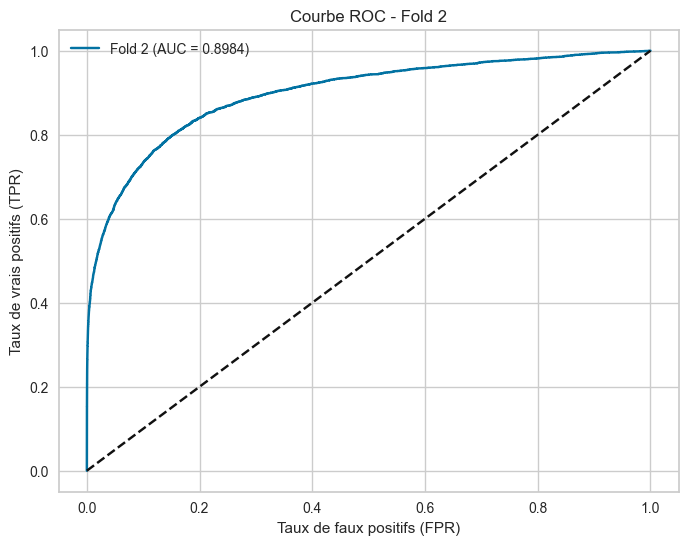

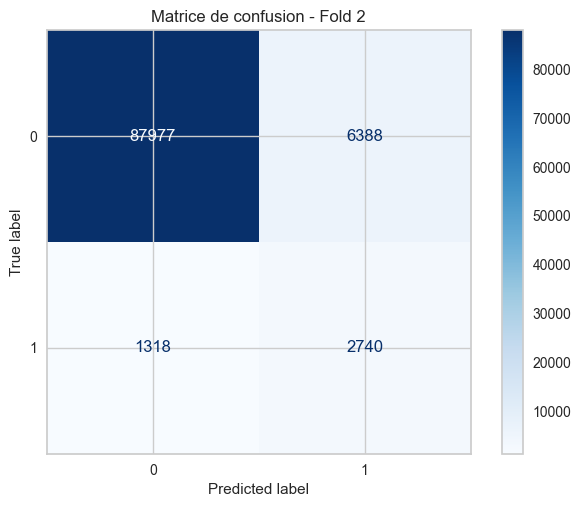

Fold 3
[LightGBM] [Info] Number of positive: 9894, number of negative: 285377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33176
[LightGBM] [Info] Number of data points in the train set: 295271, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's auc: 0.894093
AUC: 0.8941


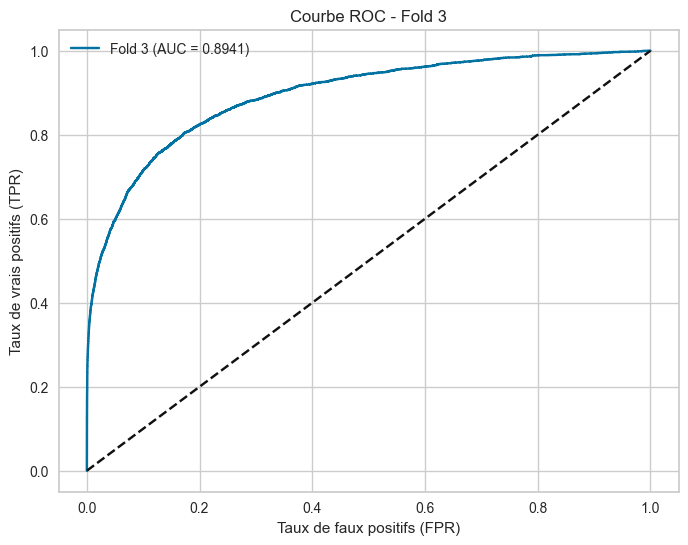

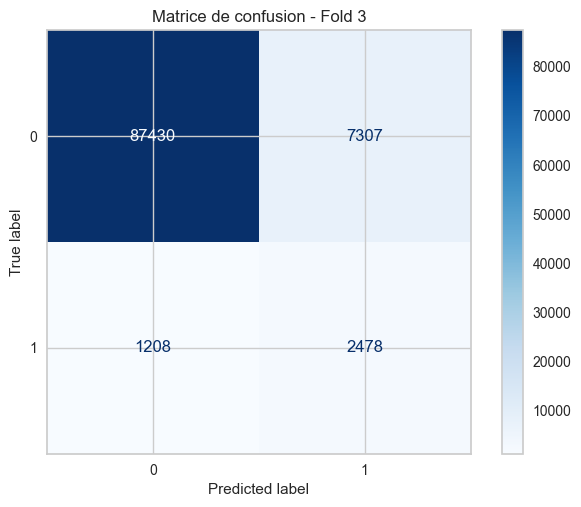

Fold 4
[LightGBM] [Info] Number of positive: 13580, number of negative: 380114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.357884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32863
[LightGBM] [Info] Number of data points in the train set: 393694, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's auc: 0.913711
AUC: 0.9137


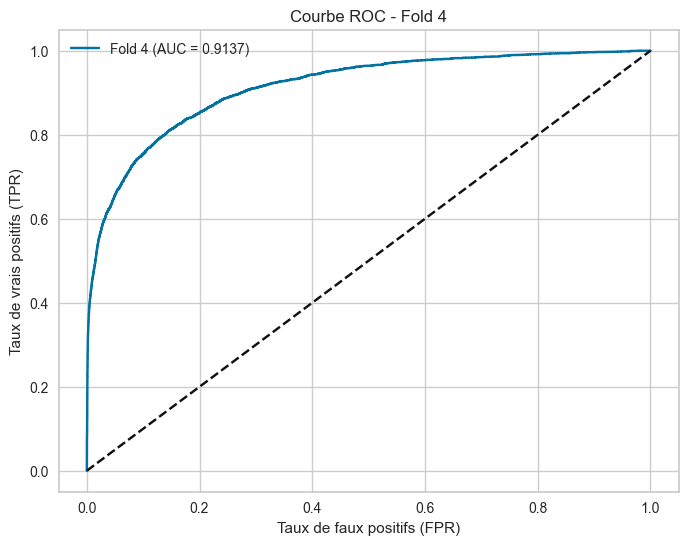

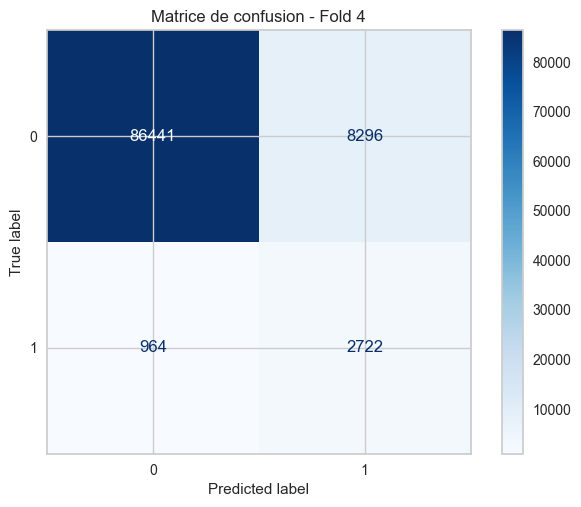

Fold 5
[LightGBM] [Info] Number of positive: 17266, number of negative: 474851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.486650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32827
[LightGBM] [Info] Number of data points in the train set: 492117, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[457]	valid_0's auc: 0.91769
AUC: 0.9177


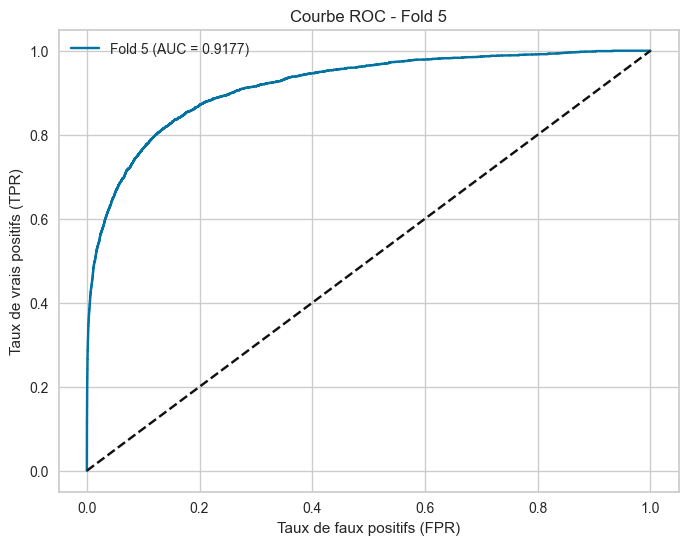

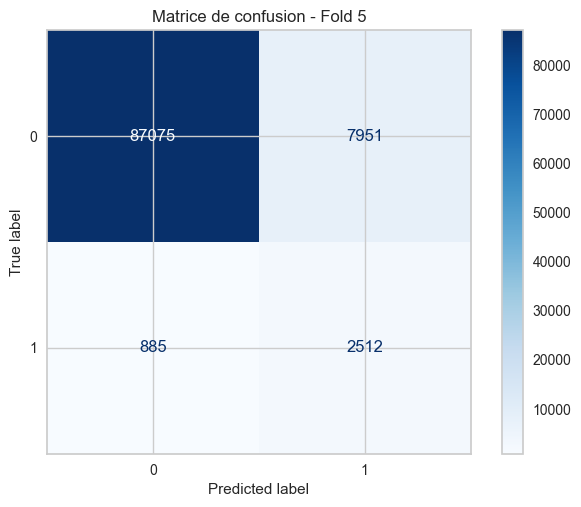

Score AUC moyen: 0.9023 ± 0.0116


In [121]:
from lightgbm import LGBMClassifier
# Paramètres du modèle
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_estimators': 1000,
}

folds = TimeSeriesSplit(n_splits=5)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f"AUC: {auc:.4f}")
    auc_scores.append(auc)

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title(f"Courbe ROC - Fold {fold + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Matrice de confusion
    y_pred_class = (y_pred >= 0.5).astype(int)
    cm = confusion_matrix(y_val, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matrice de confusion - Fold {fold + 1}")
    plt.show()

# Affichage du score AUC moyen
print(f"Score AUC moyen: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")


Le critère auc est un bon indicateur pour mesurer la performance des modèles quand les données sont 
déséquilibrés. D'après ce critère le modèle lgbm est le meilleur

## Importance des features

In [122]:
# Paramètres
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_estimators': 1000,
}

folds = TimeSeriesSplit(n_splits=5)
auc_scores = []
# Initialiser un DataFrame pour stocker les importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

# Boucle d'entraînement avec importance des variables
for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=50)]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f"AUC: {auc:.4f}")
    auc_scores.append(auc)
    # Ajouter les importances pour ce fold
    feature_importances[f'fold_{fold + 1}'] = model.feature_importances_
print(f"\n✅ Moyenne AUC sur les folds: {np.mean(auc_scores):.4f}")


Fold 1
[LightGBM] [Info] Number of positive: 2529, number of negative: 95896
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31728
[LightGBM] [Info] Number of data points in the train set: 98425, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.88754
AUC: 0.8875
Fold 2
[LightGBM] [Info] Number of positive: 5836, number of negative: 191012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

C:\Users\pc\AppData\Local\Temp\ipykernel_17928\2820031368.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(20), x='average', y='feature', palette='viridis')


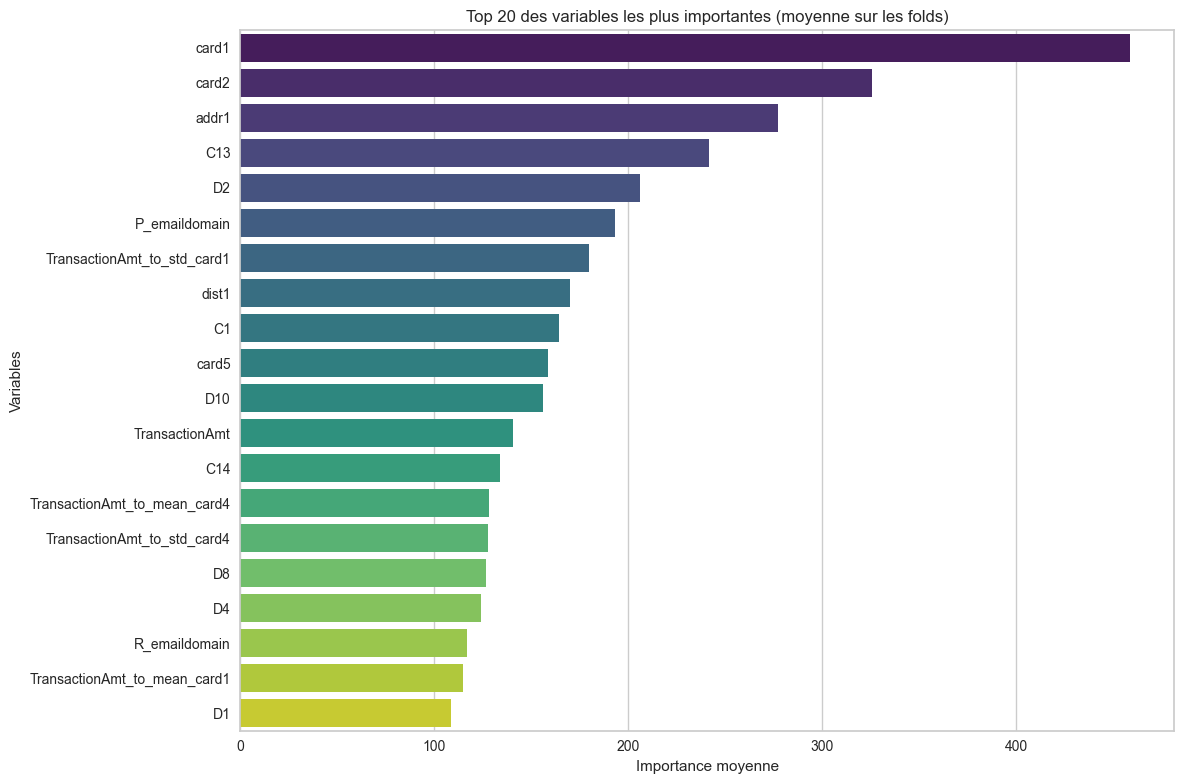

In [123]:
# Moyenne des importances
feature_importances['average'] = feature_importances[[f'fold_{i+1}' for i in range(folds.n_splits)]].mean(axis=1)

# Trier par importance moyenne
feature_importances = feature_importances.sort_values(by='average', ascending=False)

# ➤ Tracer le graphique
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances.head(20), x='average', y='feature', palette='viridis')
plt.title("Top 20 des variables les plus importantes (moyenne sur les folds)")
plt.xlabel("Importance moyenne")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

In [124]:
import pickle

with open('Classifiers/clf_0.pkl', 'wb') as f:
    pickle.dump(model, f)